# k-means

In [3]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [793]:
480*480 / 400

576.0

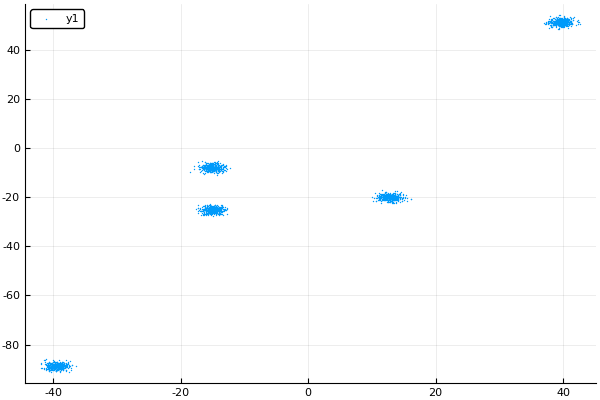

In [801]:
data = Array{Float64}(0,2)
for k = 1:5
    data = [data; randn(400, 2) .+ randn(1,2)*40]
end
scatter(data[:,1], data[:,2], markerstrokewidth=0, markersize=1)

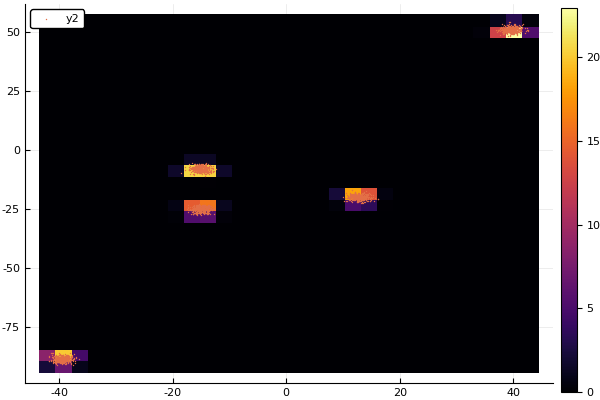

In [802]:
bins=30
minval = minimum(data, 1) .|> floor
maxval = maximum(data, 1) .|> ceil

x = minval[1]:(maxval[1]-minval[1])/bins:maxval[1]
y = minval[2]:(maxval[2]-minval[2])/bins:maxval[2]

mesh = zeros(bins+1, bins+1)
for i=1:bins+1
    for j=1:bins+1
        mesh[i,j] = sum((data .- [x[i] y[j]]).^2, 2) |> kernel((maxval[1]-minval[1])/bins*2) |> sum
    end
end

heatmap(x, y, mesh')
scatter!(data[:,1], data[:,2], markerstrokewidth=0, markersize=1)
# # terran = zeros()


In [768]:
startidx = zeros(Int64, 15)
for i = 1:10
    j = indmax(mesh)
    startidx[i] = j
    
    mesh[[j-1, j, j+1, j+31, j-31]]=0
end

startpoint = zeros(15, 2)
for i=1:15
    startpoint[i, :] = [x[startidx[i]%31], y[Int(ceil(startidx[i]/31))]]
end

LoadError: [91mBoundsError: attempt to access 31-element StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}} at index [0][39m

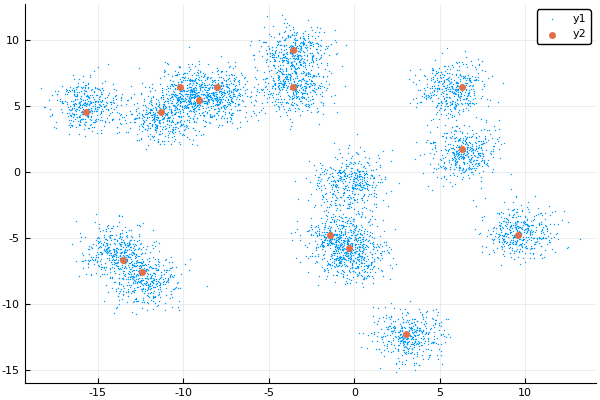

In [764]:
scatter(data[:,1], data[:,2], markerstrokewidth=0, markersize=1)
scatter!(startpoint[:,1], startpoint[:,2], markerstrokewidth=0, markersize=5)

In [729]:
x[301%21], y[Int(ceil(301 / 21))]
# 301%21

(-3.1, 5.8)

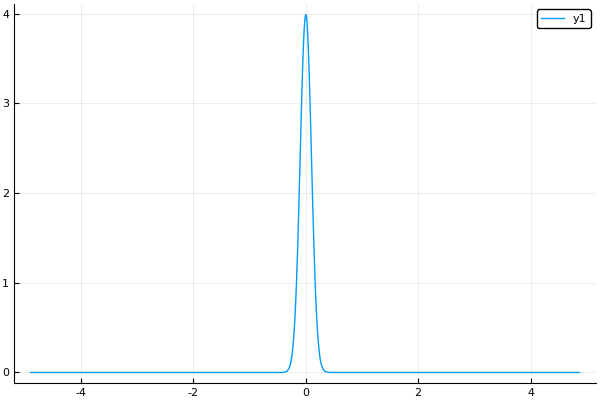

In [667]:
kernel = (sigma) -> begin
    (x) -> 1/sqrt(2pi)/sigma * exp.(-x.^2/2/sigma^2)
end
plot(kernel(0.1))

In [782]:
function kmeans_itr(data::Array{T, 2}; k=2, step=500, lr=0.1) where {T<:Number}
    items, ndim = size(data)
    
    kernel = (sigma) -> begin
        (x) -> 1/sqrt(2pi)/sigma * exp.(-x.^2/2/sigma^2)
    end
    
    bins=20
    minval = minimum(data, 1) .|> floor
    maxval = maximum(data, 1) .|> ceil

#     x = minval[1]:(maxval[1]-minval[1])/bins:maxval[1]
#     y = minval[2]:(maxval[2]-minval[2])/bins:maxval[2]
    axis = zeros(ndim, bins+1)
    for i=1:ndim
        axis[i,:] = collect(minval[i]:(maxval[i]-minval[i])/bins:maxval[i])
    end

    #TODO
    mesh = zeros(bins+1, bins+1)
    for i=1:bins+1
        for j=1:bins+1
            mesh[i,j] = sum((data .- axis[:, ]).^2, 2) |> kernel(0.4) |> sum
        end
    end
    
    startidx = zeros(Int64, k)
    for i = 1:k
        j = indmax(mesh)
        startidx[i] = j

        mesh[[j-1, j, j+1, j+21, j-21]]=0
    end
    
    
#     centroid = rand(k, ndim) .* (maximum(data,1) - minimum(data,1)) .+ minimum(data,1)
    centroid = zeros(k, ndim)
    for i=1:k
        centroid[i, :] = [x[startidx[i]%(bins+1)], y[Int(ceil(startidx[i]/(bins+1)))]]
    end
    history = zeros(k, ndim, step)
    
    distance = zeros(items, k)
    for i = 1:step
        for ki = 1:k
            distance[:,ki] = sum((data .- centroid[ki:ki,:]).^2, 2) .|> sqrt
        end

        minidx = [findmin(distance[i,:])[2] for i = 1:items]
        
        for ki = 1:k
            itemk = find(minidx .== ki)
            delta = (data[itemk, :] .- centroid[ki:ki,:]) ./ distance[itemk, ki] |> (x) -> mean(x, 1)
            
            centroid[ki, :] = centroid[ki, :] + delta[:] * lr
        end
        
        history[:,:,i] = centroid
    end
    
    label = [findmin(distance[i,:])[2] for i = 1:items]
    
    score = 0.0;
    for ki = 1:k
        rmse = (data[find(label.==ki), :] .- centroid[ki:ki, :]).^2 |> (x) -> sum(x, 1) .|> sqrt
        item = rmse |> prod |> abs
        if isnan(item)
            continue
        else
            score += item
        end
    end
    
    return centroid, label, history, score
end

function kmeans_o(data; k=2, n=10, step=1000, lr=0.01)
    center_opt, label_opt, history_opt, score_opt = kmeans_itr(data, k=6, step=step, lr=lr)
    for ni = 2:n
        center, label, history, score = kmeans_itr(data, k=6, step=step, lr=lr)
        if score < score_opt
            center_opt = center
            label_opt = label
            history_opt = history
            score_opt = score
            # @show score_opt
        end
    end
    return center_opt, label_opt, history_opt, score_opt
end

kmeans_o (generic function with 1 method)

In [803]:
@time center, label, d, s = kmeans_itr(data,k=5);
@show s;

LoadError: [91mBoundsError: attempt to access 21×21 Array{Float64,2} at index [-19][39m

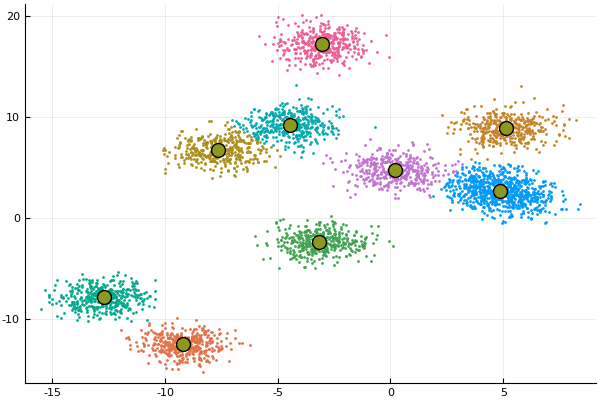

In [785]:
plot()
for i = 1:9
    l = find(label .== i)
    scatter!(data[l, 1], data[l, 2], markersize=2, markerstrokewidth=false)
end
scatter!(center[:,1], center[:, 2], markersize=10, legend=false)

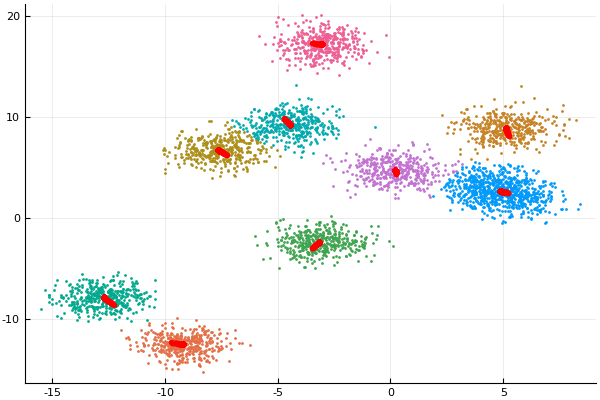

In [786]:
plot()
for i = 1:9
    l = find(label .== i)
    scatter!(data[l, 1], data[l, 2], markersize=2, markerstrokewidth=false)
end

for i = 1:9
    scatter!(d[i,1,:], d[i,2,:], markerstrokewidth=false, color=:red)
end

plot!(legend=false)

In [491]:
sqrt.(sum((data[find(label.==1), :] .- center[1:1, :]).^2, 1)) ./ center[1:1, :] |> prod

4793.422771249882

In [500]:
score = (l) -> data[find(label.==l), :] .- center[l:l, :] |> (x) -> x.^2 |> (x) -> sum(x, 1)./center[l:l, :] .|> sqrt |> prod

(::#1552) (generic function with 1 method)